### Importing Necessary Libraries

In [2]:
import os
import re
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
import seaborn as sns
from astropy.io import fits
from torchvision import models
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pytorch_msssim import SSIM
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from skimage.metrics import mean_squared_error, structural_similarity as Ssim

/home/gokul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Gathering FITS Dataset

In [3]:
dataset = "../continuum_data_subset" # Edit the dataset path
listDir = os.listdir(dataset)

listDir = sorted(listDir, key=lambda x: int(re.search(r'planet(\d+)_', x).group(1))) # Sort in ascending order of planet numbers

imgList, planetNum = [], []

for i in range(len(listDir)):
    hdu = fits.open(os.path.join(dataset, listDir[i]))
    img = hdu[0].data[0].squeeze()
    img = (img - img.min()) / (img.max() - img.min())
    imgList.append(img)
    planetNum.append(int(re.search(r'planet(\d+)_', listDir[i]).group(1)))

imgList = np.array(imgList)
planetNum = np.array(planetNum)

### Transforms, Custom Dataset, Dataloader

The image was resized to (128, 128) to address conflicts with the autoencoder. Despite the significant reduction from 600 to 128, performance remained unaffected.

In [68]:
sizeTransform = v2.Compose([
    v2.Resize((128, 128)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = Image.fromarray(image.squeeze())
            image = self.transform(image)
        
        return image, label

X_train, X_test, y_train, y_test = train_test_split(imgList, planetNum, test_size=0.1)

batchSize = 16
trainDataset = CustomDataset(X_train, y_train, transform=sizeTransform)
trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)

testDataset = CustomDataset(X_test, y_test, transform=sizeTransform)
testLoader = DataLoader(testDataset, batch_size=len(testDataset), shuffle=True)

### Example Visualization

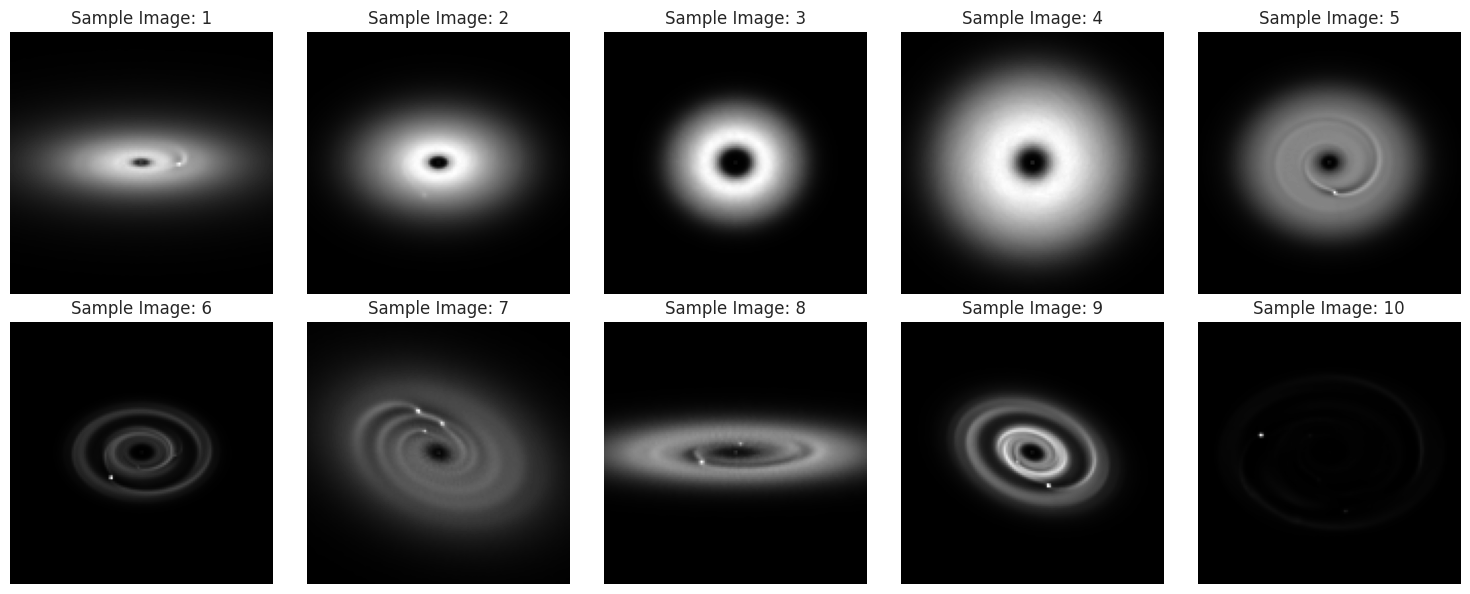

In [43]:
X, y = next(iter(trainLoader))
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

for i in range(10):
    ax[i//5][i%5].imshow(X[i].numpy().squeeze(), cmap="gray")
    ax[i//5, i%5].set_title(f"Sample Image: {i+1}")
    ax[i//5][i%5].axis('off')

plt.tight_layout()
plt.show()

### Autoencoder Network

In [77]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        channels = [1, 16, 32, 64, 128, 256, 512, 1024]
        encoder_layers, decoder_layers = [], []

        for in_ch, out_ch in zip(channels[:-1], channels[1:]):
            encoder_layers.append(nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1, bias=False))
            encoder_layers.append(nn.BatchNorm2d(out_ch))
            encoder_layers.append(nn.LeakyReLU(inplace=True))
        
        self.encoder = nn.Sequential(*encoder_layers)

        for i, (in_ch, out_ch) in enumerate(zip(channels[-1:0:-1], channels[-2::-1])):
            decoder_layers.append(nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1, bias=False))
            decoder_layers.append(nn.BatchNorm2d(out_ch))
            decoder_layers.append(nn.LeakyReLU(inplace=True))
        
        self.decoder = nn.Sequential(*decoder_layers)
    
    def forward(self, x):
        x1 = self.encoder[2](x)
        x2 = self.encoder[5](x1)
        x3 = self.encoder[8](x2)
        features = self.encoder(x)
        y = self.decoder(features)
        y = y + x3
        return y

## Pretrained VGG-16 for perceptual loss
class Vgg16(nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        features = models.vgg16(weights="VGG16_Weights.DEFAULT").features
        features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.to_relu_1_2 = nn.Sequential()
        self.to_relu_2_2 = nn.Sequential()
        self.to_relu_3_3 = nn.Sequential()

        for x in range(4):
            self.to_relu_1_2.add_module(str(x), features[x])
        for x in range(4, 9):   
            self.to_relu_2_2.add_module(str(x), features[x])
        for x in range(9, 16):   
            self.to_relu_3_3.add_module(str(x), features[x])
        
        for param in self.parameters():
            param.requires_grad = False
    
    def forward(self, x):
        f1 = self.to_relu_1_2(x)
        f2 = self.to_relu_2_2(f1)
        f3 = self.to_relu_3_3(f2)
        return f1, f2, f3

### Loss Function, Optimizer

In [78]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class SSIM_Loss(SSIM):
    def forward(self, img1, img2):
        return 100*(1 - super(SSIM_Loss, self).forward(img1, img2))
    
model = ConvAutoEncoder().to(device=device)
l1_loss = nn.L1Loss()
ssim = SSIM_Loss(data_range=1.0, size_average=True, channel=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

perceptual_network = Vgg16().to(device=device)

### Train function

In [79]:
def trainModel(model, vgg, l1_loss, ssim, optimizer, iteration):
    epochs = iteration

    trainLoss = []
    # loss component weights, best fit after numerous experiments
    MSE_WEIGHT, SSIM_WEIGHT, RECON_WEIGHT = 0.45, 0.1, 0.45

    iteration_count = 0
    total_iterations = len(trainLoader) * epochs

    with tqdm(total=total_iterations, desc="Training Progress") as pbar:

        for _ in range(epochs):
            model.train()
            batchLoss, batchReconLoss, batchPixelLoss, batchSSIMLoss = [], [], [], []

            for X, _ in trainLoader:
                X = X.to(device)
                yHat = model(X)

                ## Perceptual Loss
                content_f1, content_f2, content_f3 = vgg(X)
                yhat_f1, yhat_f2, yhat_f3 = vgg(yHat)
                recon_loss = (
                    F.l1_loss(yhat_f1, content_f1) + 
                    F.l1_loss(yhat_f2, content_f2) +
                    F.l1_loss(yhat_f3, content_f3)
                ) / 3
                batchReconLoss.append(recon_loss.item())

                ## L1 Loss
                pixel_loss = l1_loss(yHat, X)
                batchPixelLoss.append(pixel_loss.item())

                ## SSIM Loss
                ssim_loss = ssim(yHat, X)
                batchSSIMLoss.append(ssim_loss.item())

                ## Total Loss
                total_loss = RECON_WEIGHT * recon_loss + MSE_WEIGHT * pixel_loss + SSIM_WEIGHT * ssim_loss

                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()

                batchLoss.append(total_loss.item())
                iteration_count += 1

                if iteration_count % 200 == 0:
                    avg_train_loss = np.mean(batchLoss)
                    avg_mse_loss = np.mean(batchPixelLoss)
                    avg_ssim_loss = np.mean(batchSSIMLoss)
                    avg_recon_loss = np.mean(batchReconLoss)
                    trainLoss.append(avg_train_loss)
                    pbar.set_postfix_str(f"Total Loss: {avg_train_loss:.3f}, Perceptual Loss: {avg_recon_loss:.3f}, MSE Loss: {avg_mse_loss: .3f}, MSSSIM Loss: {avg_ssim_loss: .3f}")
                pbar.update(1)

    checkpoint = {
        "weights": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, "task_image_based.pth")

    return trainLoss, model

### Training the network (~ 7 mins) (Remove first line to train)

In [ ]:
%%script echo skipping
trainLoss, model = trainModel(model, perceptual_network, l1_loss, ssim, optimizer, iteration=500)

Training Progress: 100%|██████████| 4500/4500 [06:55<00:00, 10.83it/s, Total Loss: 0.006, Perceptual Loss: 0.001, MSE Loss:  0.002, MSSSIM Loss:  0.043]


### Loading the pretrained-weights

In [81]:
checkpoint_dir = "task_image_based.pth" # Edit the model checkpoint path
checkpoint = torch.load(checkpoint_dir, weights_only=True)

model.load_state_dict(checkpoint["weights"])

<All keys matched successfully>

### Testing the model

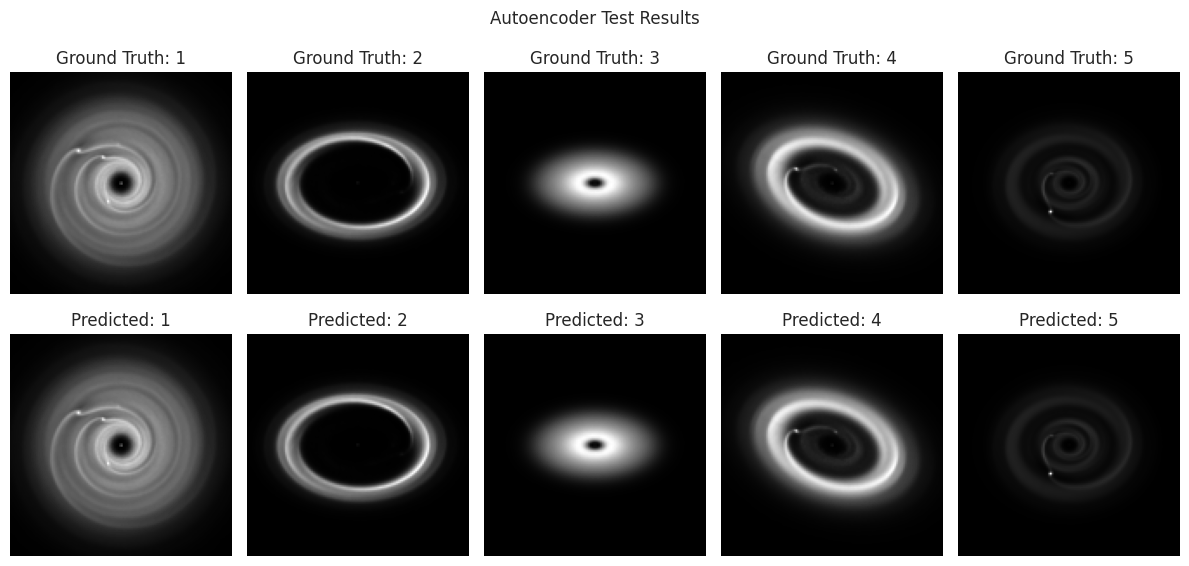

In [86]:
X, y = next(iter(testLoader))
X = X.to(device)
model.eval().to(device)
yHat = model(X)

_, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))

for i in range(5):
    ## ground truth image
    ax[0, i].imshow(X[i].squeeze().cpu().detach(), cmap="gray")
    ax[0, i].set_title(f"Ground Truth: {i+1}")
    ax[0, i].axis("off")
    ## predicted reconstruction
    ax[1, i].imshow(yHat[i].squeeze().cpu().detach(), cmap="gray")
    ax[1, i].set_title(f"Predicted: {i+1}")
    ax[1, i].axis("off")

plt.suptitle("Autoencoder Test Results")
plt.tight_layout()
plt.show()

### SSIM, MSE - Test Distribution

Plotting SSIM, MSE over all test images as a probability distribution using histograms

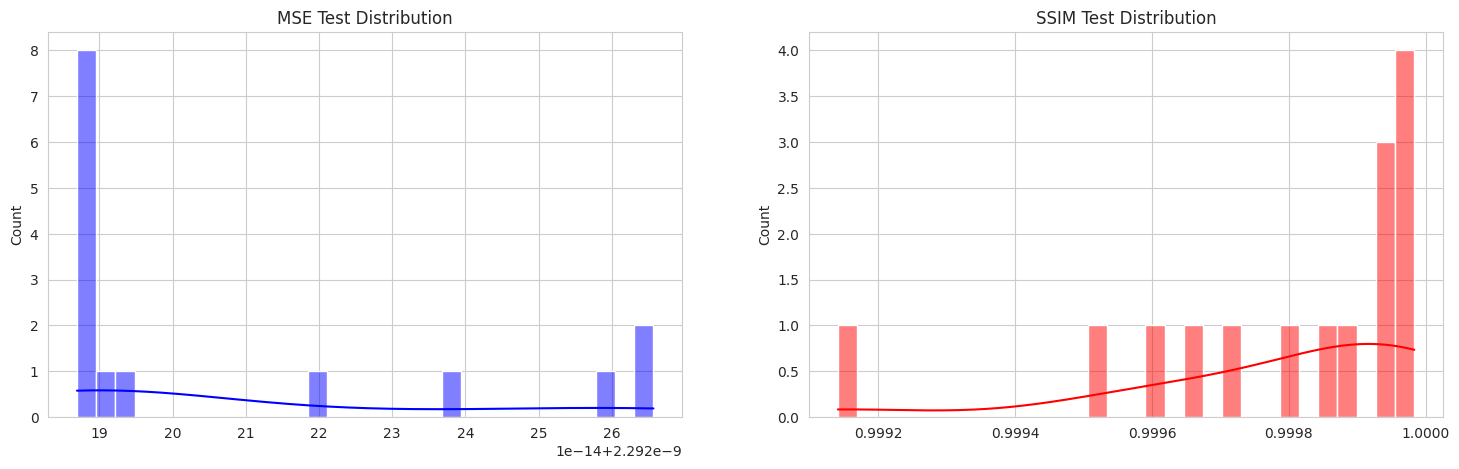

In [90]:
def test_eval():
    mse_list, ssim_list = [], []

    for Xtest, _ in testLoader:
        Xtest = Xtest.to(device)
        yHattest = model(Xtest).detach().cpu()

        for i in range(Xtest.shape[0]):
            orig = Xtest[i].squeeze(0).detach().cpu().numpy()
            pred = yHattest[i].squeeze(0).numpy()

            mse = mean_squared_error(orig, pred)
            ssim = Ssim(orig, pred, data_range=pred.max()-pred.min())

            mse_list.append(mse)
            ssim_list.append(ssim)

    mse_list, ssim_list = np.array(mse_list), np.array(ssim_list)

    return mse_list, ssim_list

mse_list, ssim_list = test_eval()

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
sns.set_style("whitegrid")
sns.histplot(mse_list, bins=30, kde=True, ax=ax[0], color="blue")
ax[0].set_title("MSE Test Distribution")

sns.histplot(ssim_list, bins=30, kde=True, ax=ax[1], color="red")
ax[1].set_title("SSIM Test Distribution")

plt.show()